# A PyTorch Neural Network

Today, we'll build a straightforward Deep Neural Network (DNN) using the [PyTorch](https://pytorch.org/) library, and train it to solve a difficult problem in particle physics.

### The Problem: Top Quark Reconstruction

Top quark-antiquark pairs are _abundantly_ produced at the LHC, and are studied at the experiments there. However, detectors such as the Compact Muon Solenoid (CMS) don't detect top quarks directly. This is because their lifetime is about $10^{-24}$ seconds, meaning they decay long before they would reach the detector's instrumentation. Thus, the detector only "sees" the final-state products of the decay chain. Our problem, then, is this: **given the final-state quantities available to us from a detector, what were the momentum and energy of the top quark and antiquark?**

The top quark and antiquark always decay through the Weak interaction, (pretty much always) via the process $t \rightarrow W^+ \: b$ (and conversely $\bar{t} \rightarrow W^- \: \bar{b}$). The $b$ and $\bar{b}$ quarks _hadronize_ after being produced, forming **jets** in detectors. The $W^{\pm}$ bosons, on the other hand, also decay, either into a pair of quarks (roughly $2/3$ of the time) or into a **lepton** (electron, muon, or tau lepton) and **neutrino** (roughly $1/3$ of the time). This means there are three possible _decay channels_ for a top quark-antiquark pair:
- **fully hadronic**: Both $W^{\pm}$ bosons decay to pairs of quarks, which then hadronize. Thus, the final state contains six jets.
- **semileptonic**: One $W^{\pm}$ boson decays to a pair of quarks, and the other decays to a lepton and neutrino. Thus, the final state contains four jets, one lepton, and one corresponding neutrino.
- **dileptonic**: Both $W^{\pm}$ bosons decay to leptons and neutrinos. Thus, the final state contains two jets, two _opposite-sign_ leptons, and two corresponding neutrinos.

The task of reconstructing the top quarks' **four-momentum** (energy and momentum) contains unique challenges in each of the three decay channels. Here, we are focused on reconstructing top quarks that decay via the _dileptonic_ channel, visualized in the diagram below.

![Dileptonic $t \bar{t}$ production and decay in a proton-proton collision.](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRdV4O628S0ZiWNghVtmDgxYWCMvaYoy_zIuw&s)

Thinking a bit about the reconstruction task, you might realize that conservation of momentum and energy imply that we can simply add the four-momenta of the final-state decay products of each top quark/antiquark to obtain its four-momentum. This is true, but there are two wrinkles that prevent us from doing this in practice:
1. The neutrinos are _completely invisible_ to most particle detectors! This means that we don't measure their four-momenta at all. We do get something of a hint, in the form of **missing transverse momentum**, the overall momentum imbalance in the transverse plane (total momentum in this plane _should_ sum to zero, but with neutrinos present, the imbalance can be quite large). However, this is essentially 2 constraints on our 6 missing degrees of freedom (technically 8, but the masses of neutrinos are so small that zero is a perfectly good approximation).
2. The jets formed by $b$ and $\bar{b}$ quarks are indistinguishable, and are in fact difficult to distinguish from jets formed by other quark types. So, we have 2 (or more) jets, but we don't know which one formed from the $b$ and $\bar{b}$. This is more generally known as the problem of _jet-parton assignment_, and occurs in a wide variety of particle physics analyses (it's a HUGE combinatorial problem in the fully hadronic $t \bar{t}$ decay channel, for instance).

Of these, the first is by far the larger problem, as it means there is some inherent _ambiguity_ in our task. That is, there are potentially several possible $t$ and $\bar{t}$ momenta that could yield the same final-state observables. The best we can hope to do is find a method of making a highly educated guess! Luckily, Deep Neural Networks excel in learning how to make good guesses in tasks with this type of ambiguity.

### Our Approach: a PyTorch DNN

You'll get more details as we go, but to give you an idea of our overall approach to solving this problem, we will:
- Organize a set of physics objects (four-momentum and other information associated with a particle, jet, or event-level quantity) into a format suitable for input to a DNN.
- Construct a DNN that will accept our inputs and output 8 quantities, to be considered the four-momenta of the top quark and antiquark.
- Train the DNN on simulated dileptonic top quark-antiquark decays, from the public  [Collide-1m](https://huggingface.co/datasets/fastmachinelearning/collide-1m) dataset.
- Assess how well the trained model performs.

To get started, let's import the packages we'll need.

In [1]:
import os
# import pickle
from itertools import cycle
import numpy as np
import vector
import torch
from matplotlib import pyplot as plt

Now, we'll create a few global variables that we'll reference throughout the entire process. You should recognize most of these from previous discussions of general machine learning topics. The `device` and `model_params` might, however, be new. The `device` global variable is simply set to the PyTorch identifier for the device where we'll be training. If a GPU is available, we'll want to use that, and fall back to CPU if not. The `model_params` dictionary contains parameters that will configure the size (and dropout rate) of our DNN. We'll pass these parameters to the constructor of our PyTorch model class (it'll make more sense when you see that section).

In [2]:
save_folder = "/depot/cms/users/colberte/ml-learning/PyTorch/SavedModels"
os.makedirs(save_folder, exist_ok=True)

batch_size = 2048
valid_batch_size = 16384
epochs = 60
learning_rate = 1.0e-4
grad_clip_value = 80.0

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
model_params = {
    "d_input": 52,
    "n_layers": 4,
    "d_layers": 192,
    "d_output": 8,
    "dropout": 0.1,
}

### Setting up Datasets

Now it's time to load in our datasets. They've been prepared as PyTorch `TensorDataset`s, so all we need to do is load them from files and prepare them to be served in batches to our model. Importantly, you should create a `data` folder (alongside this notebook) and place the dataset files there (you could also place them wherever you want and alter the paths in the next cell, whatever your preference).

Notice that after loading the datasets, we pass them into PyTorch `Dataloader`s. These objects contain logic to efficiently serve us small batches of the dataset, potentially shuffling it after each full iteration. We also pass some arguments to help speed up the transfer of data to a GPU device, if one exists. For more info about datasets and dataloaders in PyTorch, check out [this tutorial](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html).

Finally, we'll be using the validation dataset to periodically check that our model is still training well. This means that we'll be iterating through it a little slower, and we want to easily start over whenever we happen to hit the end. The `itertools` library (a Python built-in) provides the `cycle` function, which returns an iterator that handles that logic for us.

The datasets each contain 5 PyTorch tensors:
- **Jets**: For each jet in an event, its four-momentum and a _b-tagging score_ are included. The b-tagging score represents the likelihood that the jet originated from a $b$ quark. There are potentially several jets per event, so the tensor's shape is $[N_{\text{events}} \times N_{\text{jets}} \times 5]$. Note that $N_{\text{jets}}$ might be different per-event. How might this be handled?
- **Leptons**: Because we know (or more precisely, hypothesize) that the top quark-antiquark pair decayed via the dileptonic channel, we can always find a _lepton-antilepton pair_ that we take to be part of the final state. We package these together, including their four-momenta and electric charge. Thus, this tensor's shape is $[N_{\text{events}} \times 2 \times 5]$.
- **MET**: This is simply the 2-dimensional missing transverse momentum vector for each event. It has shape $[N_{\text{events}} \times 1 \times 2]$, to match the number of dimensions of the other tensors.
- **Padding Mask**: We don't use this tensor at all in this tutorial! What do you think it represents?
- **Targets**: The four-momenta of the top quark and antiquark, in that order. This tensor has shape $[N_{\text{events}} \times 2 \times 4]$.

In these datasets, four-momenta are represented simply as $[p_x, p_y, p_z, E]$. This is **not** the case for the Collide datasets in general, which provide the quantities $[p_T, \eta, \phi, m]$. I've transformed the coordinates to the more straighforward system for us. In case you're curious, the coordinate $\eta$ refers to [pseudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity), a coordinate, related to $\theta$, commonly used in collider physics due to the shape of the detectors.

#### Exercise 1
Take a moment to look at the datasets before creating the dataloaders. Before you move on, make sure you can answer the questions: how many jets are included for each event? What happens if an event has fewer jets than this?

You can retrieve the tensors from a `TensorDataset` by simply indexing into it like you would a Python list. Additionally, you may find the `torch.Tensor.size()` function useful.

In [5]:
train_dataset = torch.load("data/ttbar_dilepton_collide_train.pt", weights_only=False)
valid_dataset = torch.load("data/ttbar_dilepton_collide_valid.pt", weights_only=False)

In [6]:
# Your code here!

In [7]:
if torch.cuda.is_available():
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True, drop_last=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, num_workers=1, pin_memory=True, drop_last=True)
else:
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, drop_last=True)

In [8]:
valid_dataloader_iterator = cycle(valid_dataloader)

### Defining the Model

Now, it's time to define the _architecture_ of our model. We'll use a straightforward _Multi-Layer Perceptron_ (MLP), also known as a fully-connected neural network. This is the simplest, and most universal, type of neural network.

In PyTorch, we define model architectures by writing classes that inherit from the `torch.nn.Module` class (if you don't know what [class inheritance](https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)) is in programming, the details of this section might be a little opaque, but the essence of what we're doing should still be clear). In order to subclass `Module`, we have to define a constructor (`__init__`) that calls the base constructor (the first line in ours, `super().__init__()`, does this), and a `forward` method, which defines how the model computes its outputs from its inputs. As an important note, you should usually **NEVER** actually call the `forward` method - you'll notice we never do it here! Instead, you'll directly _call an instance of the model_. PyTorch does some extra behind-the-scenes work before calling our `forward` that essentially allows training to function!

You'll see in the implementation below, that we define the class, and we use a `torch.nn.Sequential` module to stack our layers one after another.

#### Exercise 2
Our class is missing a key ingredient: actual layers! Build up the neural network with `torch.nn.Linear` layers and `torch.nn.ReLU` activation functions. Simply append them to the `layers` list, and they'll be inorporated into the sequential stack.

In [9]:
class MLPModel(torch.nn.Module):
    def __init__(self, d_input, n_layers, d_layers, d_output, dropout=0.0):
        super().__init__() # IMPORTANT: This allows the `torch.nn.Module` to initialize and prepare to register our model blocks

        # This builds up the layers we want in our network
        layers = [torch.nn.Linear(d_input, d_layers), torch.nn.ReLU()]
        for idx in range(n_layers-1):
            layers.append(torch.nn.Linear(d_layers, d_layers))
            layers.append(torch.nn.ReLU())
            if (dropout > 0.0):
                layers.append(torch.nn.Dropout(dropout))
        layers.append(torch.nn.Linear(d_layers, d_output))

        self.stack = torch.nn.Sequential(*layers) # Registers our layers as a single feedforward block

    def forward(self, inputs):
        return self.stack(inputs)

Now, we can create an instance of our class - this is our actual model! Note that we use the `model_params` dict we defined earlier. Defining structures like that helps keep all our settings in one place, and makes it easier to log the different configurations we try.

We can also examine the number of trainable parameters our model has. This is a key indicator of the overall size and complexity of our model.

In [10]:
model = MLPModel(**model_params)
model = model.to(device)

In [11]:
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable parameters: 122888


### Setting up Training

Here we define a **loss function** and **optimization algorithm** that we'll use to train our model. A wide variety of these are implemented in the PyTorch library; these are a couple of my favorites. Feel free to explore different options here, you might be surprised how strongly these choices can affect your training!

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)

In [13]:
loss_function = torch.nn.L1Loss(reduction="mean")

### Training Montage!

Here's the fun part: training!

In PyTorch, training loops are implemented _manually_. While this seems like extra complication, it actually gives us a lot of flexibility. The basic steps in a training loop are, for each batch of training data:
1. Zero out the model's gradients, so they don't erroneously accumulate (this is the call to `optimizer.zero_grad()`).
2. Pass the data batch through the model and obtain outputs.
3. Calculate loss between the outputs and targets.
4. Run `loss.backward()` to calculate the derivatives of the loss with respect to the model's trainable parameters, and `optimizer.step()` to use those derivatives to update the parameters, attempting to lower (and eventually minimize) the loss. These two calls implement _backpropagation_ via automatic differentiation and some form of _gradient descent_.

You'll also notice that we run multiple _epochs_, or passes over the entire training dataset. It can sometimes take many epochs for a model to fully train! We also pass some of our validation data through the model after each epoch, and record the loss. This will help us see if our model is overfitting.

Finally, we save our trained model using [TorchScript](https://docs.pytorch.org/docs/stable/jit.html), so we can spin it back up and run it later.

#### Exercise 3
Our MLP model expects a _flat vector of inputs_ and outputs a _flat vector_ for each event. But, our data comes in several tensors, each with a complex shape. You'll need to flatten them out and concatenate the inputs into one large (52-dimensional) vector per event, and flatten the targets as well.

#### Exercise 3.5 (Optional)
You'll notice that, at the end of each epoch of training, we pass a batch of validation data through our model, and compute the loss, but we don't do much with that. We could, however, implement a variant of _early stopping_ where we keep track of the lowest validation loss so far, and save a copy of our model each time it reaches a lower value. That way, we'll always save the model with the best validation performance (at least, theoretically)! Try adding that to the block at the end of the training loop.

In [14]:
train_loss = []
valid_loss = []
# min_valid_loss = float("inf")
# min_loss_epoch = 0

In [15]:
for epoch in range(1, epochs+1):
    print(f"Starting epoch {epoch}.")
    model.train()
    for batch, (jets, leptons, met, pad_mask, target) in enumerate(train_dataloader):
        optimizer.zero_grad()

        jets = jets.reshape([-1, 40])
        leptons = leptons.reshape([-1, 10])
        met = met.reshape([-1, 2])
        #pad_mask = pad_mask.to(device)
        inputs = torch.concat([jets, leptons, met], dim=-1).to(device)
        
        target = target.reshape([-1, 8]).to(device)

        pred = model(inputs)

        loss = loss_function(pred, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value) # gradient clipping
        optimizer.step()

        # if (batch % 10 == 0):
        train_loss_number = loss.detach().to("cpu").item()
        train_loss.append(train_loss_number)

    model.eval()
    with torch.no_grad():
        jets_valid, leptons_valid, met_valid, pad_mask_valid, target_valid = next(valid_dataloader_iterator)
        jets_valid = jets_valid.reshape([-1, 40])
        leptons_valid = leptons_valid.reshape([-1, 10])
        met_valid = met_valid.reshape([-1, 2])
        #pad_mask_valid = pad_mask_valid.to(device)
        inputs_valid = torch.concat([jets_valid, leptons_valid, met_valid], dim=-1).to(device)
        
        target_valid = target_valid.reshape([-1, 8]).to(device)

        pred_valid = model(inputs_valid)

        loss_valid = loss_function(pred_valid, target_valid)

        valid_loss_number = loss_valid.detach().to('cpu').item()
        valid_loss.append(valid_loss_number)

        # if (valid_loss_number <= min_valid_loss):
        #     min_valid_loss = valid_loss_number
        #     min_loss_epoch = epoch
        #     # Save model with lowest validation loss
        #     torch.jit.script(model).save(save_folder+"/best_mlp.pt")

print("Finished.")

Starting epoch 1.
Starting epoch 2.
Starting epoch 3.
Starting epoch 4.
Starting epoch 5.
Starting epoch 6.
Starting epoch 7.
Starting epoch 8.
Starting epoch 9.
Starting epoch 10.
Starting epoch 11.
Starting epoch 12.
Starting epoch 13.
Starting epoch 14.
Starting epoch 15.
Starting epoch 16.
Starting epoch 17.
Starting epoch 18.
Starting epoch 19.
Starting epoch 20.
Starting epoch 21.
Starting epoch 22.
Starting epoch 23.
Starting epoch 24.
Starting epoch 25.
Starting epoch 26.
Starting epoch 27.
Starting epoch 28.
Starting epoch 29.
Starting epoch 30.
Starting epoch 31.
Starting epoch 32.
Starting epoch 33.
Starting epoch 34.
Starting epoch 35.
Starting epoch 36.
Starting epoch 37.
Starting epoch 38.
Starting epoch 39.
Starting epoch 40.
Starting epoch 41.
Starting epoch 42.
Starting epoch 43.
Starting epoch 44.
Starting epoch 45.
Starting epoch 46.
Starting epoch 47.
Starting epoch 48.
Starting epoch 49.
Starting epoch 50.
Starting epoch 51.
Starting epoch 52.
Starting epoch 53.
St

In [16]:
torch.jit.script(model).save(save_folder+"/final_mlp.pt")

### Evaluating the Results

We can look at how training proceeded by plotting the loss.

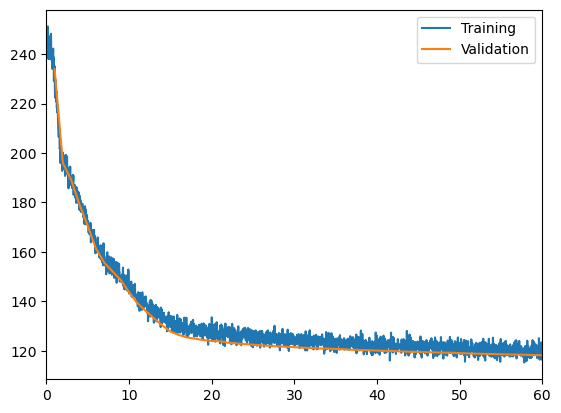

In [17]:
epochs_list = np.arange(1, epochs+1)
steps_list = np.linspace(0, epochs, len(train_loss))

fig, ax = plt.subplots()

ax.set_xlim(0, epochs)
#ax.set_ylim(bottom=0)

ax.plot(steps_list, train_loss, label="Training")
ax.plot(epochs_list, valid_loss, label="Validation")

ax.legend()

plt.show()
plt.close()

That's some pretty good training!

#### Exercise 4
How might we get a visual glimpse into how well our model performs? Try to draw some plots that show how well (or badly) the model reconstructed its targets.

### Wrapping Up

Hope this was fun, y'all should play with it and explore!

Some questions and next steps to think about:
1. We used raw four-momenta, along with electric charges and tagging scores, as inputs to our model. These different features have vastly different orders of magnitude and distributions. Do you think this is good or bad for a model like this one? If it's bad, what might we do about it?